In [1]:
import numpy as np
from random import *

# Set up environment

In [2]:
####################
# Helper Functions #
####################

def accumulate(fn, initial, seq):
    if not seq:
        return initial
    else:
        return fn(seq[0], 
                  accumulate(fn, initial, seq[1:]))
    
def flatten(mat):
    return [num for row in mat for num in row]

def has_zero(mat):
    return 0 in flatten(mat)

def transpose(mat):
    return list(map(list,zip(*mat)))

# Before Transpose:
# 1 2 3 4
# 5 6 7 8
# 9 10 11 12
# 13 14 15 16

# After Transpose
# 1 5 9 13
# 2 6 10 14
# 3 7 11 15
# 4 8 12 16


def reverse(mat):
    return list(map(lambda row: list(reversed(row)),mat))

# Before Reverse:
# 1 2 3 4
# 5 6 7 8
# 9 10 11 12
# 13 14 15 16

# After Reverse
# 4 3 2 1
# 8 7 6 5
# 12 11 10 9
# 16 15 14 13


###################
# Game Matrix ADT #
###################

def new_game_matrix(n):
    matrix = []
    for i in range(n):
        matrix.append([0] * n)
    return matrix


def add_two(mat):
    if not has_zero(mat):
        return mat
    a = randint(0, len(mat)-1)
    b = randint(0, len(mat)-1)
    while mat[a][b] != 0:
        a = randint(0, len(mat)-1)
        b = randint(0, len(mat)-1)
    mat[a][b] = 2
    return mat

def game_status(mat):
#     for row in mat:
#         for element in row:
#             if element == 8192:
#                 return 'win'

    if has_zero(mat):
        return 'not over'
    for i in range(len(mat)): #Check horizontally
        for j in range(len(mat[0])-1):
            if mat[i][j] == mat[i][j+1]:
                return 'not over'
    for i in range(len(mat)-1): #Check vertically
        for j in range(len(mat[0])):
            if mat[i][j] == mat[i+1][j]:
                return 'not over'
    return 'lose'

def merge_left(matrix):
    def merge_row(row):
        merged_row, prev_tile, score_increment = [], 0, 0
        # pack element by element left-wards
        for tile in row:
            if tile == 0: continue
            if prev_tile == 0:
                prev_tile = tile
            elif prev_tile != tile:
                merged_row.append(prev_tile)
                prev_tile = tile
            else:
                merged_row.append(prev_tile*2)
                score_increment += prev_tile*2
                prev_tile = 0
        merged_row.append(prev_tile) # valid regardless whether there are merges or not
        # top up zeros
        while len(merged_row) != len(row):
            merged_row.append(0)
        return (merged_row, merged_row != row, score_increment)

    return accumulate(lambda first, rest: ([first[0]] + rest[0], 
                                            first[1] or rest[1], 
                                            first[2] + rest[2]),
                      ([], False, 0),
                      list(map(merge_row, matrix)))

def merge_right(mat):
    mat, valid, score = merge_left(reverse(mat))
    return (reverse(mat), valid, score)

def merge_up(mat):
    mat, valid, score = merge_left(transpose(mat))
    return (transpose(mat), valid, score)

def merge_down(mat):
    mat, valid, score = merge_left(reverse(transpose(mat)))
    return (transpose(reverse(mat)), valid, score)


###################
# Game Record ADT #
###################
                
def make_new_record(mat, score):
    return (mat, score)
def get_record_matrix(record):
    return record[0]
def get_record_score(record):
    return record[1]


####################
# Game Records ADT #
####################

def new_records():
    return []
def add_record(new_record, records):
    NUM_OF_UNDOS = 3
    records.append(new_record)
    if num_of_records(records) > NUM_OF_UNDOS:
        records = records[-NUM_OF_UNDOS:]
    return records
def num_of_records(records):
    return len(records)
def is_empty(records):
    return num_of_records(records) <= 0
def pop_last_record(records):
    if not is_empty(records):
        last_record = records.pop()
        return (get_record_matrix(last_record),
                get_record_score(last_record),
                records)
    else:
        return (None, None, records)

##################
# Game State ADT #
##################

def make_state(matrix, total_score, history):
    return (matrix, total_score, history)
def get_matrix(state):
    return state[0]
def get_score(state):
    return state[1]
def get_history(state):
    return state[2]
def make_new_game(n):
    starting_matrix = add_two(add_two(new_game_matrix(n)))
    return make_state(starting_matrix, 0, new_records())

def execute_move(state, matrix_updater):   
    current_score = get_score(state)
    next_matrix, valid_move, score_increment = matrix_updater(get_matrix(state))
    if not valid_move:
        return (state, False)
    else:
        updated_history = ()
        updated_state = make_state(add_two(next_matrix),
                                   current_score + score_increment,
                                   updated_history)
        return (updated_state, True)
def left(state):
    return execute_move(state, merge_left)
def right(state):
    return execute_move(state, merge_right)
def up(state):
    return execute_move(state, merge_up)
def down(state):
    return execute_move(state, merge_down)

def undo(state):
    records = get_history(state)
    matrix, score, records = pop_last_record(records)
    if matrix:
        return (make_state(matrix, score, records), True)
    else:
        return (state, False)    

game_logic = {
    'make_new_game': make_new_game,
    'game_status': game_status,
    'get_score': get_score,
    'get_matrix': get_matrix,
    'up': up,
    'down': down,
    'left': left,
    'right': right,
    'undo': undo
}

# Random AI

In [3]:
def random_move(current_state):
    index = np.random.randint(4)
    return ["up", "down", "left", "right"][index]

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def printboardstate(boardstate):
    mat, score, _ = boardstate
    sns.heatmap(mat, annot = True, 
            square = True, cbar = False, cmap = 'YlOrBr', fmt = 'd')
    plt.title('Game State with Score ' + str(score))
    plt.axis('off')
    plt.show()

Initial state:


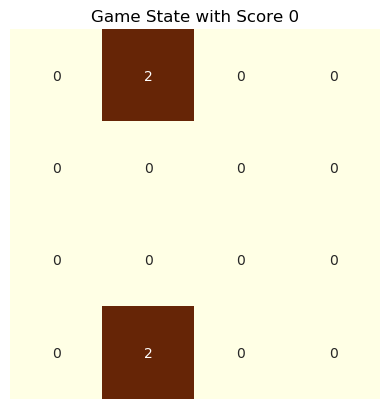

Final state:


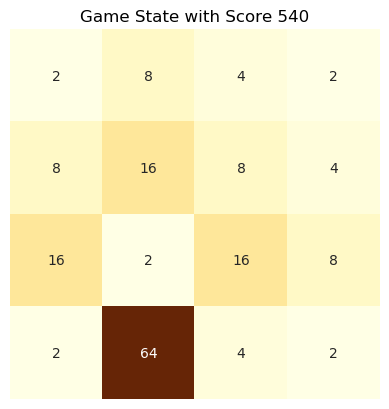

In [5]:
current_state = make_new_game(4)

print('Initial state:')
printboardstate(current_state)

while game_status(get_matrix(current_state)) == "not over":
    best_move = random_move(current_state)
    best_move = game_logic[best_move]
    current_state, _ = best_move(current_state)
    
print('Final state:')
printboardstate(current_state)

# Monte Carlo AI

In [46]:
def playthrough(gamestate, num_tries, max_depth):
    ''' Takes in a game state, and plays randomly till the end num_tries times, returns the final score '''
    score = 0
    for i in range(num_tries):
        newstate = gamestate
        depth = 0
        while game_status(get_matrix(newstate)) == "not over" and depth<max_depth:
            best_move = random_move(newstate)
            best_move = game_logic[best_move]
            newstate, _ = best_move(newstate)
            
            depth += 1
        score += newstate[1] - gamestate[1]
    
    return score/num_tries

Initial state:


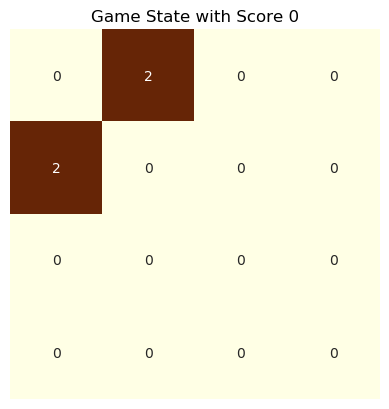

Score:
0 0 4 4 8 12 20 24 24 24 24 24 24 28 40 44 44 48 52 68 84 88 88 92 100 104 108 108 112 120 124 124 124 124 124 124 128 136 152 192 240 244 292 292 296 296 300 304 312 312 312 312 316 316 320 320 336 344 348 348 348 352 360 380 384 384 388 396 400 400 480 480 496 496 516 548 560 576 608 608 612 620 624 628 636 636 640 640 644 712 736 740 748 748 752 752 756 760 912 912 912 916 916 916 920 936 940 948 1004 1008 1028 1036 1040 1040 1072 1072 1072 1172 1172 1172 1176 1176 1180 1192 1192 1196 1220 1240 1248 1264 1268 1268 1304 1320 1356 1424 1560 1560 1564 1568 1568 1568 1568 1572 1580 1584 1584 1600 1616 1620 1624 1624 1624 1628 1628 1632 1640 1644 1668 1668 1668 1668 1672 1700 1704 1704 1704 1704 1736 1736 1736 1736 1744 1784 1800 1800 1804 1804 2084 2092 2124 2128 2128 2128 2128 2132 2144 2144 2236 2236 2244 2252 2260 2264 2272 2276 2280 2284 2328 2360 2392 2392 2392 2396 2396 2400 2408 2408 2412 2416 2424 2424 2428 2440 2456 2460 2460 2460 2464 2532 2540 2556 2556 2560 2708 2716 

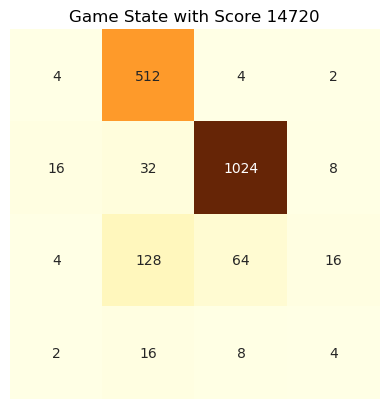

In [47]:
initial_state = make_new_game(4)
# initial_state = ([[0, 0, 0, 0], [8, 2, 0, 0], [4, 0, 0, 0], [4, 64, 8, 2]], 348, ())

print('Initial state:')
printboardstate(initial_state)

num_tries = 200
max_depth = 8
    
current_state = initial_state
print('Score:')
while game_status(get_matrix(current_state)) == "not over":
    # Only evaluate for valid moves
    bestscore = -1
    bestmove = ""
    
    for move in ['up', 'down', 'left', 'right']:
        _, valid = game_logic[move](current_state)
        if not valid: continue
        
        # perform monte carlo simulation for each of the valid moves
        montecarlo_state, _ = game_logic[move](current_state)
        montecarlo_score = playthrough(montecarlo_state, num_tries, max_depth)
        if montecarlo_score > bestscore:
            bestscore = montecarlo_score
            bestmove = move
    
    # do the move with the highest score
    current_state, _ = game_logic[bestmove](current_state)
    
#     print('Best move:', bestmove, 'Score:', current_state[1])
    print(current_state[1], end = ' ')
    
print('Final state:')
printboardstate(current_state)


# Monte Carlo Tree Search based AI

Initial state:


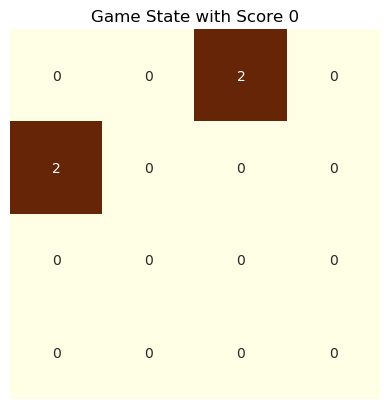

Score:
0 0 4 4 8 12 20 20 20 24 28 28 28 32 36 52 56 56 60 64 64 64 64 68 68 68 72 80 96 96 100 108 112 116 116 120 156 164 164 168 168 168 168 172 180 184 220 252 272 272 272 272 272 276 288 288 352 384 388 388 388 392 392 392 392 392 504 512 520 520 520 520 544 544 548 556 572 616 616 704 712 716 716 720 720 724 732 732 732 736 744 748 748 748 752 756 756 900 908 932 952 952 956 956 956 960 968 968 972 980 984 988 988 1024 1024 1028 1052 1072 1084 1088 1128 1128 1128 1132 1140 1140 1144 1144 1168 1180 1180 1180 1180 1196 1296 1296 1304 1316 1316 1320 1352 1368 1372 1408 1480 1480 1480 1484 1488 1628 1628 1632 1632 1636 1644 1644 1644 1648 1660 1660 1660 1664 1664 1668 1976 1980 1984 1984 1984 1984 1988 2000 2008 2008 2012 2012 2016 2020 2020 2024 2108 2148 2164 2168 2168 2172 2172 2172 2172 2172 2176 2184 2184 2188 2196 2200 2308 2332 2348 2380 2384 2384 2384 2388 2388 2388 2392 2400 2404 2412 2416 2416 2420 2500 2508 2508 2512 2512 2516 2516 2652 2656 2680 2700 2708 2708 2728 2732 2

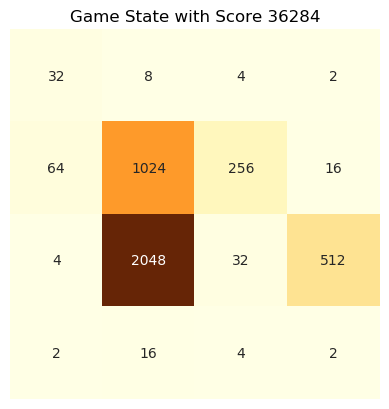

In [50]:
initial_state = make_new_game(4)

print('Initial state:')
printboardstate(initial_state)

debug = False

initial_tries = 20
num_tries = 400
max_depth = 15

indextomove = {0: 'up', 1: 'down', 2: 'left', 3: 'right'}
movetoindex = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
    
current_state = initial_state
print('Score:')
while game_status(get_matrix(current_state)) == "not over":
    # Only evaluate for valid moves
    bestscore = -1
    bestmove = ""
    validmoves = []
    
    action_score = np.array([0, 0, 0, 0])
    action_tries = np.array([0, 0, 0, 0])
    
    exploration_tries, exploration_score = 0, 0
    
    maxscore = 0
    
    for move in ['up', 'down', 'left', 'right']:
        _, valid = game_logic[move](current_state)
        if valid: validmoves.append(move)
        # if not valid, still increment the initial tries variable for that move to avoid division by 0
        else: 
            action_tries[movetoindex[move]] = initial_tries
            action_score[movetoindex[move]] = -1000000
            continue
        
        # do an initial exploration of each valid move
        for tries in range(initial_tries):
            # perform monte carlo simulation for that move
            montecarlo_state, _ = game_logic[move](current_state)
            montecarlo_score = playthrough(montecarlo_state, 1, max_depth)

            # add the score and tries to the action node
            maxindex = movetoindex[move]
            action_tries[maxindex] += 1
            action_score[maxindex] += montecarlo_score
            
            exploration_tries += 1
            exploration_score += montecarlo_score
    
    # we peg the exploration constant to the average montecarlo score of the initial trials
    c = exploration_score/exploration_tries
#     c = 10
            
    for totaltries in range(num_tries):
        
        # perform an explore-exploit tradeoff calculation to find out which move to go first
        action_heuristic = action_score/action_tries + c*np.sqrt(np.log(totaltries+1)/action_tries)
        
#         print(action_heuristic)
#         print(np.sqrt((totaltries+1)/action_tries))
#         print('Exploration',c*np.sqrt(np.log(totaltries+1)/action_tries))
        
        maxindex = np.argmax(action_heuristic)        
        move = indextomove[maxindex]
        
        # perform monte carlo simulation for that move
        montecarlo_state, _ = game_logic[move](current_state)
        montecarlo_score = playthrough(montecarlo_state, 1, max_depth)
        
        # add the score and tries to the action node
        action_tries[maxindex] += 1
        action_score[maxindex] += montecarlo_score
        
        
    if debug:
        print('Exploration Factor', c)
        print('Number of tries', action_tries)
        print('Average score', action_score/action_tries)

        
    # best move is the highest score
#     bestmoveindex = np.where(action_tries == max(action_tries))[0][0]
    bestmoveindex = np.argmax(action_score/action_tries)
    bestmove = indextomove[bestmoveindex]
    
    # do the move with the highest score
    current_state, _ = game_logic[bestmove](current_state)
    
    if debug:
        print('Best move:', bestmove)
    print(current_state[1], end = ' ')

print('Final state:')
printboardstate(current_state)

# DQN